In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector
import warnings

In [31]:
amsterdam_weekdays = pd.read_csv('datas/amsterdam_weekdays.csv')
amsterdam_weekends = pd.read_csv('datas/amsterdam_weekends.csv')

In [32]:
print(amsterdam_weekdays.shape)
print(amsterdam_weekends.shape)

(1103, 20)
(977, 20)


In [33]:
def combine(csv_1,col_1,csv_2,col_2):
    csv_1['week time'] = col_1
    csv_2['week time'] = col_2
    csv_1.drop(columns = ['Unnamed: 0'],inplace=True)
    csv_2.drop(columns = ['Unnamed: 0'],inplace=True)
    merged = pd.concat([csv_1, csv_2])
    return merged

In [34]:
amsterdam = combine(amsterdam_weekdays,'weekdays',amsterdam_weekends,'weekends')

In [35]:
amsterdam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 976
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     2080 non-null   float64
 1   room_type                   2080 non-null   object 
 2   room_shared                 2080 non-null   bool   
 3   room_private                2080 non-null   bool   
 4   person_capacity             2080 non-null   float64
 5   host_is_superhost           2080 non-null   bool   
 6   multi                       2080 non-null   int64  
 7   biz                         2080 non-null   int64  
 8   cleanliness_rating          2080 non-null   float64
 9   guest_satisfaction_overall  2080 non-null   float64
 10  bedrooms                    2080 non-null   int64  
 11  dist                        2080 non-null   float64
 12  metro_dist                  2080 non-null   float64
 13  attr_index                  2080 n

# <span style="color:#000000; font-size:1em;">ANALYZE THE DATA (AMSTERDAM)</span>

In [36]:
amsterdam.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,week time
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,weekdays
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,weekdays
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,weekdays
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,weekdays
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,weekdays


In [8]:
amsterdam.describe()

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000
mean,573.112795,2.781731,0.283173,0.105288,9.465865,94.514423,1.292308,2.825052,1.089367,269.064730,14.246499,335.712818,26.097566,4.890472,52.364637
std,430.658406,1.032634,0.450648,0.306999,0.813421,6.350874,0.736683,2.082573,0.831669,195.193411,10.335158,226.473943,17.720931,0.038736,0.018885
min,128.887118,2.000000,0.000000,0.000000,2.000000,20.000000,0.000000,0.015045,0.036517,40.890060,2.164941,50.823991,3.545205,4.775500,52.290310
25%,331.825745,2.000000,0.000000,0.000000,9.000000,92.000000,1.000000,1.349250,0.464639,130.557523,6.913108,165.528716,12.739227,4.870400,52.354565
50%,460.244183,2.000000,0.000000,0.000000,10.000000,96.000000,1.000000,2.329951,0.861928,208.577946,11.044224,263.073705,20.767760,4.889430,52.365340
75%,686.441075,4.000000,1.000000,0.000000,10.000000,99.000000,2.000000,3.627072,1.504676,378.208244,20.026378,456.506331,35.437042,4.906743,52.375255
max,8130.668104,6.000000,1.000000,1.000000,10.000000,100.000000,5.000000,11.195932,4.411915,1888.737455,100.000000,1435.102401,100.000000,5.010770,52.423480


# <span style="color:#339999; font-size:1em;">AMSTERDAM : PRICES DISTRIBUTION</span>

# <span style="color:#a2b3b2; font-size:0.75em;">DISTRIBUTION OF PRICES

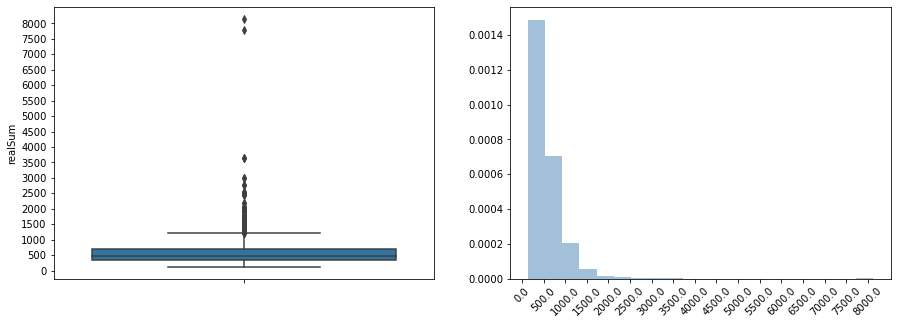

In [39]:
warnings.filterwarnings('ignore')

plt.figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(y='realSum', data=amsterdam, ax=axs[0])
axs[0].set_yticks(np.arange(0,max(amsterdam['realSum']),500))

axs[1].hist(amsterdam['realSum'], bins=20, alpha=0.5, color='steelblue', density=True)
axs[1].set_xticklabels(np.arange(0,max(amsterdam['realSum']),500),rotation=45)
axs[1].set_xticks(np.arange(0,max(amsterdam['realSum']),500))

plt.show()

# <span style="color:#2c7873; font-size:0.5em;">FINDINGS : </span>
<p style="color:#2c7873; font-size:1em;">
    From the above plots it can be seen that the Majority of Prices of AirBnb's in Amsterdam range from 250 to 750. Looking at the shape of the distribution, it is a Right-Skewed Ditributtion, and we also have a few High outliers.
</p>

# <span style="color:#a2b3b2; font-size:0.75em;">DISTRIBUTION OF NUMERIC VARIABLES

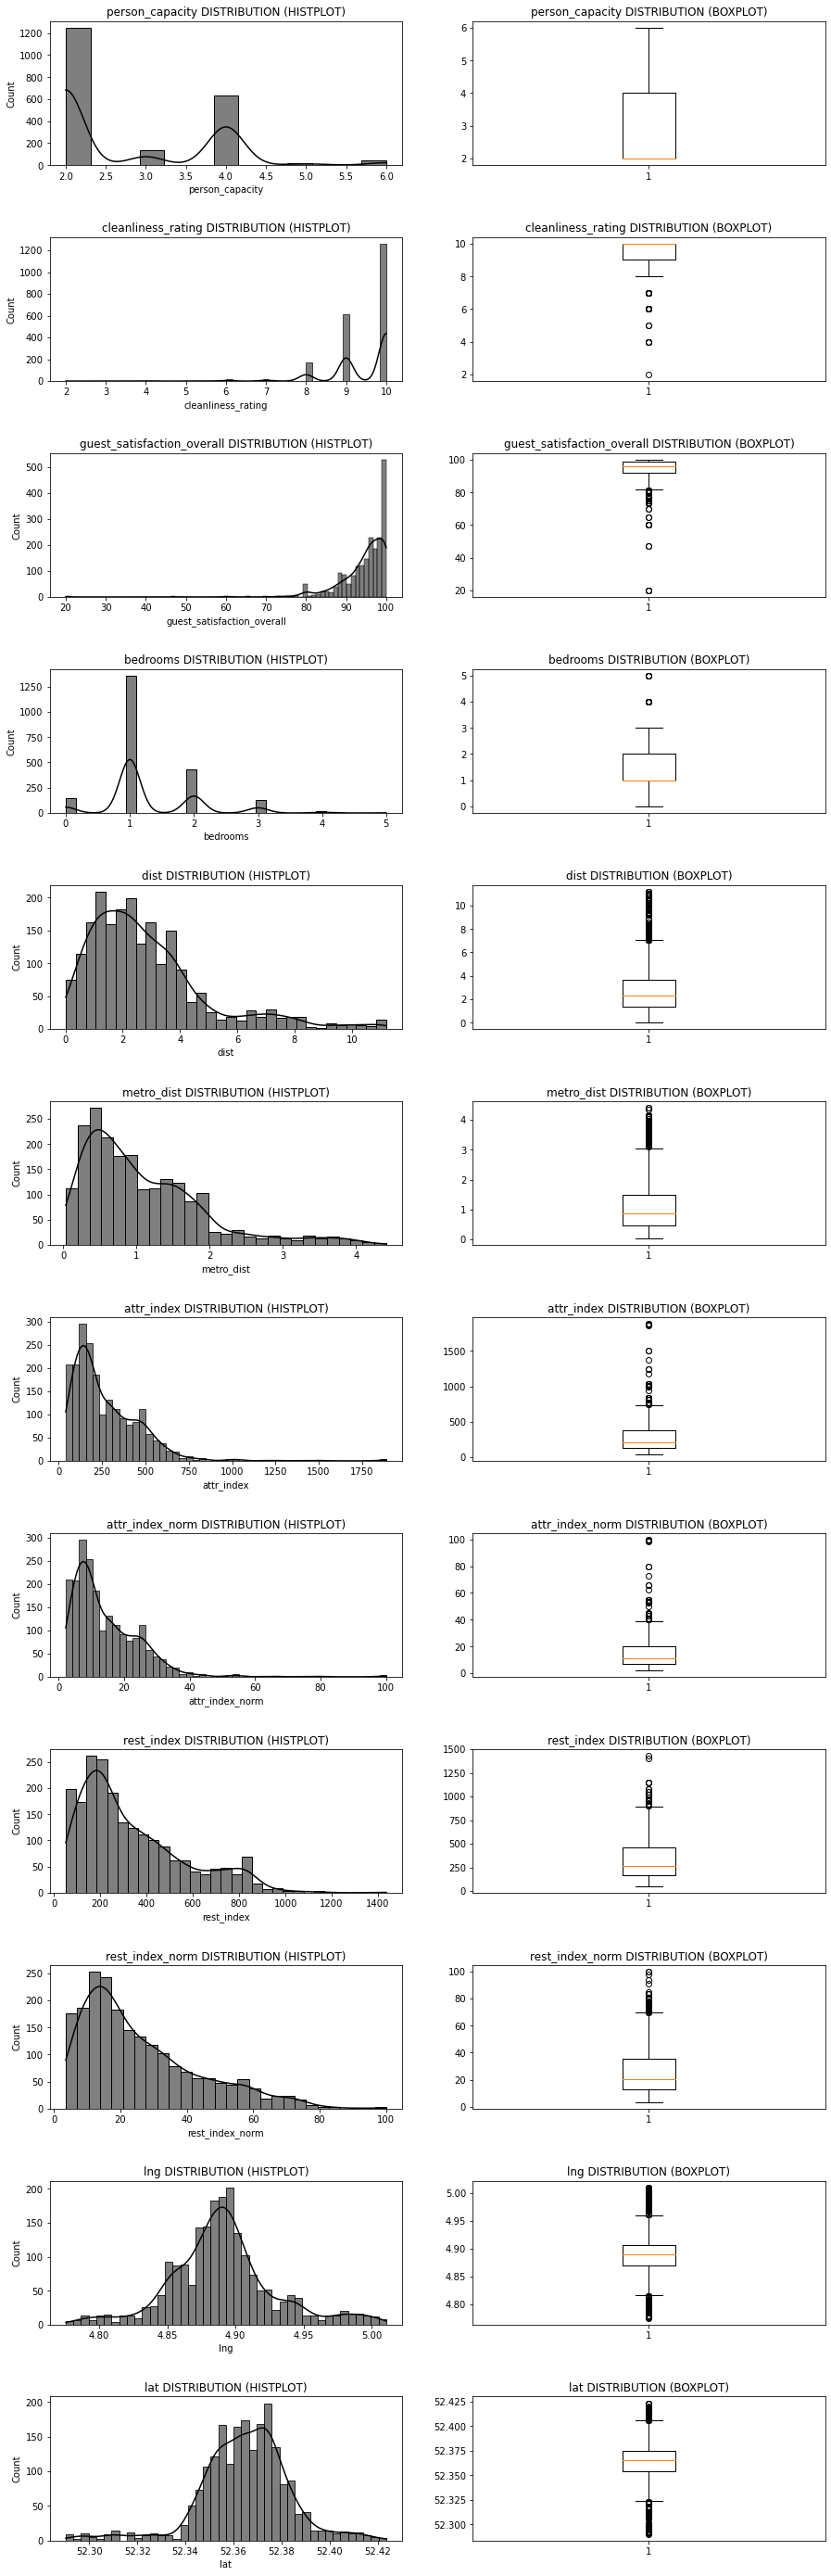

In [40]:
amsterdam_numerical_features = list(amsterdam.select_dtypes(include=['int64','float64']).columns[i] for i in [1,4,5,6,7,8,9,10,11,12,13,14])

def amsterdam_numeric_disstribution_plotter(feature,color,row):
    sns.histplot(data=amsterdam[feature],ax=axes[row,0],kde=True,color=color)
    axes[row,0].set_title(str(feature)+" DISTRIBUTION (HISTPLOT)")
    axes[row,1].boxplot(amsterdam[feature])
    axes[row,1].set_title(str(feature)+" DISTRIBUTION (BOXPLOT)")
    
    
plt.figure
fig, axes = plt.subplots(nrows=12, ncols=2, figsize=(15, 50))
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[0] , '000000' , 0)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[1] , '000000' , 1)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[2] , '000000' , 2)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[3] , '000000' , 3)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[4] , '000000' , 4)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[5] , '000000' , 5)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[6] , '000000' , 6)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[7] , '000000' , 7)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[8] , '000000' , 8)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[9] , '000000' , 9)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[10] , '000000' , 10)
amsterdam_numeric_disstribution_plotter( amsterdam_numerical_features[11] , '000000' , 11)

plt.subplots_adjust(hspace=0.50)
plt.show()


# <span style="color:#2c7873; font-size:0.5em;">IMPORTANT FINDINGS : </span>
<p style="color:#2c7873; font-size:1em;">
    Room Capacity : For AirBnb listings is Amsterdam, Majority of rooms either have the capacity for 4 People, or for Two people. Generalizing it, roughly 75% of listings on our data had capacity for 2 - 4 people. <br><br>
Cleanliness Rating : Data suggests that almost all the Listings have recieved a cleanliness rating greater than 8. Even the listings with rating 7 were outliers in our data. Thus the overall cleanliness rating of Amsterrdam Listings is quite high.<br><br>
Guest Satisfaction Overall : The Guest satisfaction skews to the left, meaning that most listings achieved satisfaction scores above 80. In our data, satisfaction scores of less that 80 were low outliers <br><br> 
Bedrooms : The number of bedrooms in the majority of listings range from studio apartments to 3 bedrooms. Noticing that most of the listings had capacity of 2-4 people, this distribution of number of bedrooms can relate to it. <br><br>
dist : Majority of listings are within 7 km's of the city centre. <br><br>
metro_dist : Majority of listings are within 3 km's from the nearest metro stations.<br><br>

</p>

# <span style="color:#a2b3b2; font-size:0.75em;">VARIABLES RELATION WITH PRICE

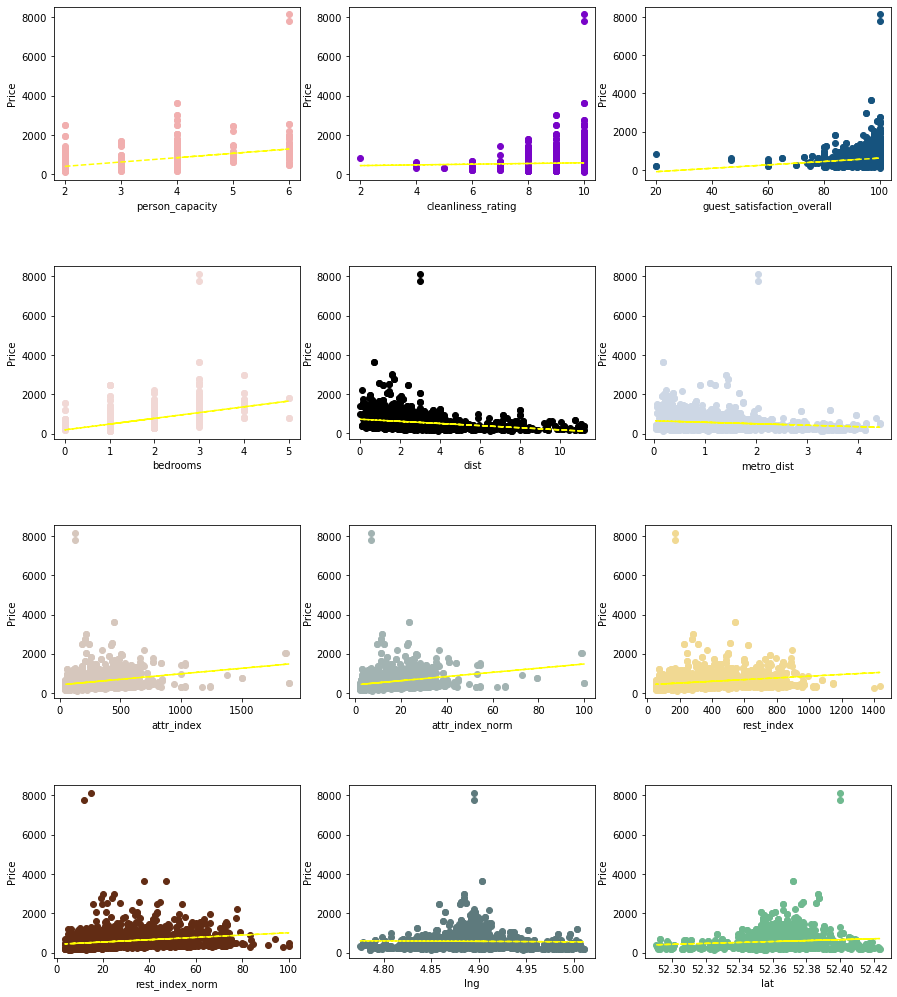

In [41]:
amsterdam_numerical_features = list(amsterdam.select_dtypes(include=['int64','float64']).columns[i] for i in [1,4,5,6,7,8,9,10,11,12,13,14])

def amsterdam_numeric_plotter(x,y,feature,color):
    axes[x,y].scatter(y=amsterdam["realSum"], x=amsterdam[feature],c=color)
    trend_line = np.poly1d(np.polyfit(amsterdam[feature], amsterdam["realSum"], 1))
    axes[x,y].plot(amsterdam[feature], trend_line(amsterdam[feature]), "r--",c='yellow')
    axes[x,y].set_ylabel("Price")
    axes[x,y].set_xlabel(feature)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 17.5))

amsterdam_numeric_plotter(0 , 0 , amsterdam_numerical_features[0] , '#f1afaf' )
amsterdam_numeric_plotter(0 , 1 , amsterdam_numerical_features[1] , '#7804c8' )
amsterdam_numeric_plotter(0 , 2 , amsterdam_numerical_features[2] , '#16537e' )
amsterdam_numeric_plotter(1 , 0 , amsterdam_numerical_features[3] , '#f1d8d5' )
amsterdam_numeric_plotter(1 , 1 , amsterdam_numerical_features[4] , '#000000' )
amsterdam_numeric_plotter(1 , 2 , amsterdam_numerical_features[5] , '#cdd7e5' )
amsterdam_numeric_plotter(2 , 0 , amsterdam_numerical_features[6] , '#d6c7bd' )
amsterdam_numeric_plotter(2 , 1 , amsterdam_numerical_features[7] , '#a2b3b2' )
amsterdam_numeric_plotter(2 , 2 , amsterdam_numerical_features[8] , '#f1d993' )
amsterdam_numeric_plotter(3 , 0 , amsterdam_numerical_features[9] , '#622c14' )
amsterdam_numeric_plotter(3 , 1 , amsterdam_numerical_features[10] , '#5e7a7d' )
amsterdam_numeric_plotter(3 , 2 , amsterdam_numerical_features[11] , '#6fb98f' )

plt.subplots_adjust(hspace=0.5)

# <span style="color:#a2b3b2; font-size:0.75em;">CORELLATION AMONG INPUTS and WITH OUTPUTS

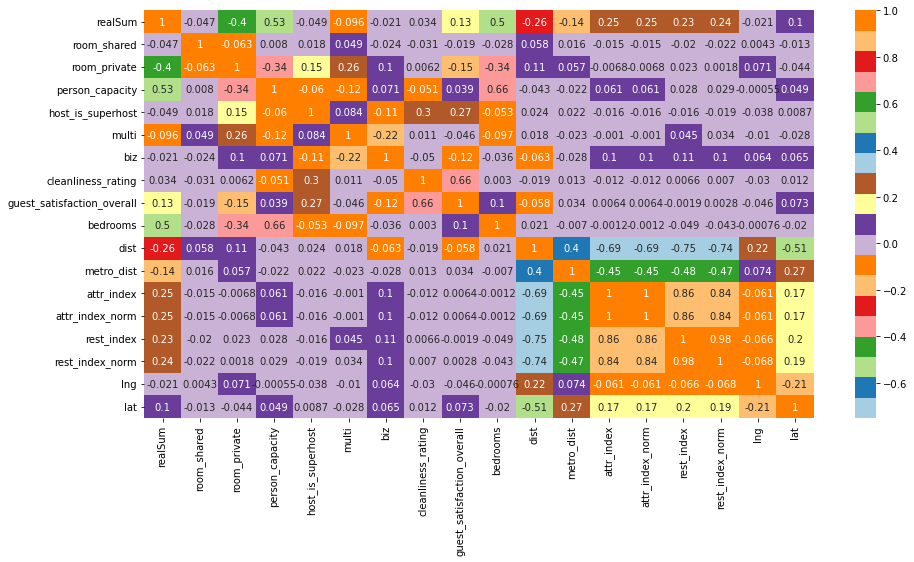

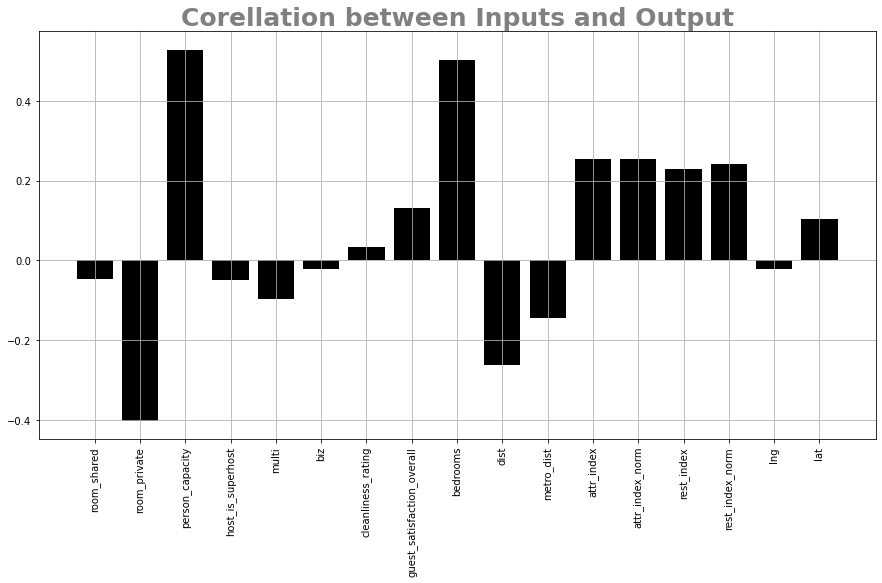

In [42]:
plt.figure
fig, axs = plt.subplots(1, 1, figsize=(15, 7.5))
sns.heatmap(amsterdam.corr(),cmap=sns.color_palette("Paired",20),annot=True)

fig2, axs2 = plt.subplots(1, 1, figsize=(15, 7.5))
axs2.bar(x = ((amsterdam.drop(columns=['realSum'])).corrwith(amsterdam['realSum'])).index, height = (((amsterdam.drop(columns=['realSum'])).corrwith(amsterdam['realSum'])).values),color='000000')
axs2.set_xticklabels(((amsterdam.drop(columns=['realSum'])).corrwith(amsterdam['realSum'])).index,rotation=90)
axs2.set_title('Corellation between Inputs and Output',fontsize=25,fontweight='bold',color='Gray')
plt.grid(True)
plt.show()

# <span style="color:#a2b3b2; font-size:0.75em;">CATEGORICAL & BINARY FEATURES, THEIR COUNTS AND RELATION WITH OUTPUT THROUGH BOXPLOT

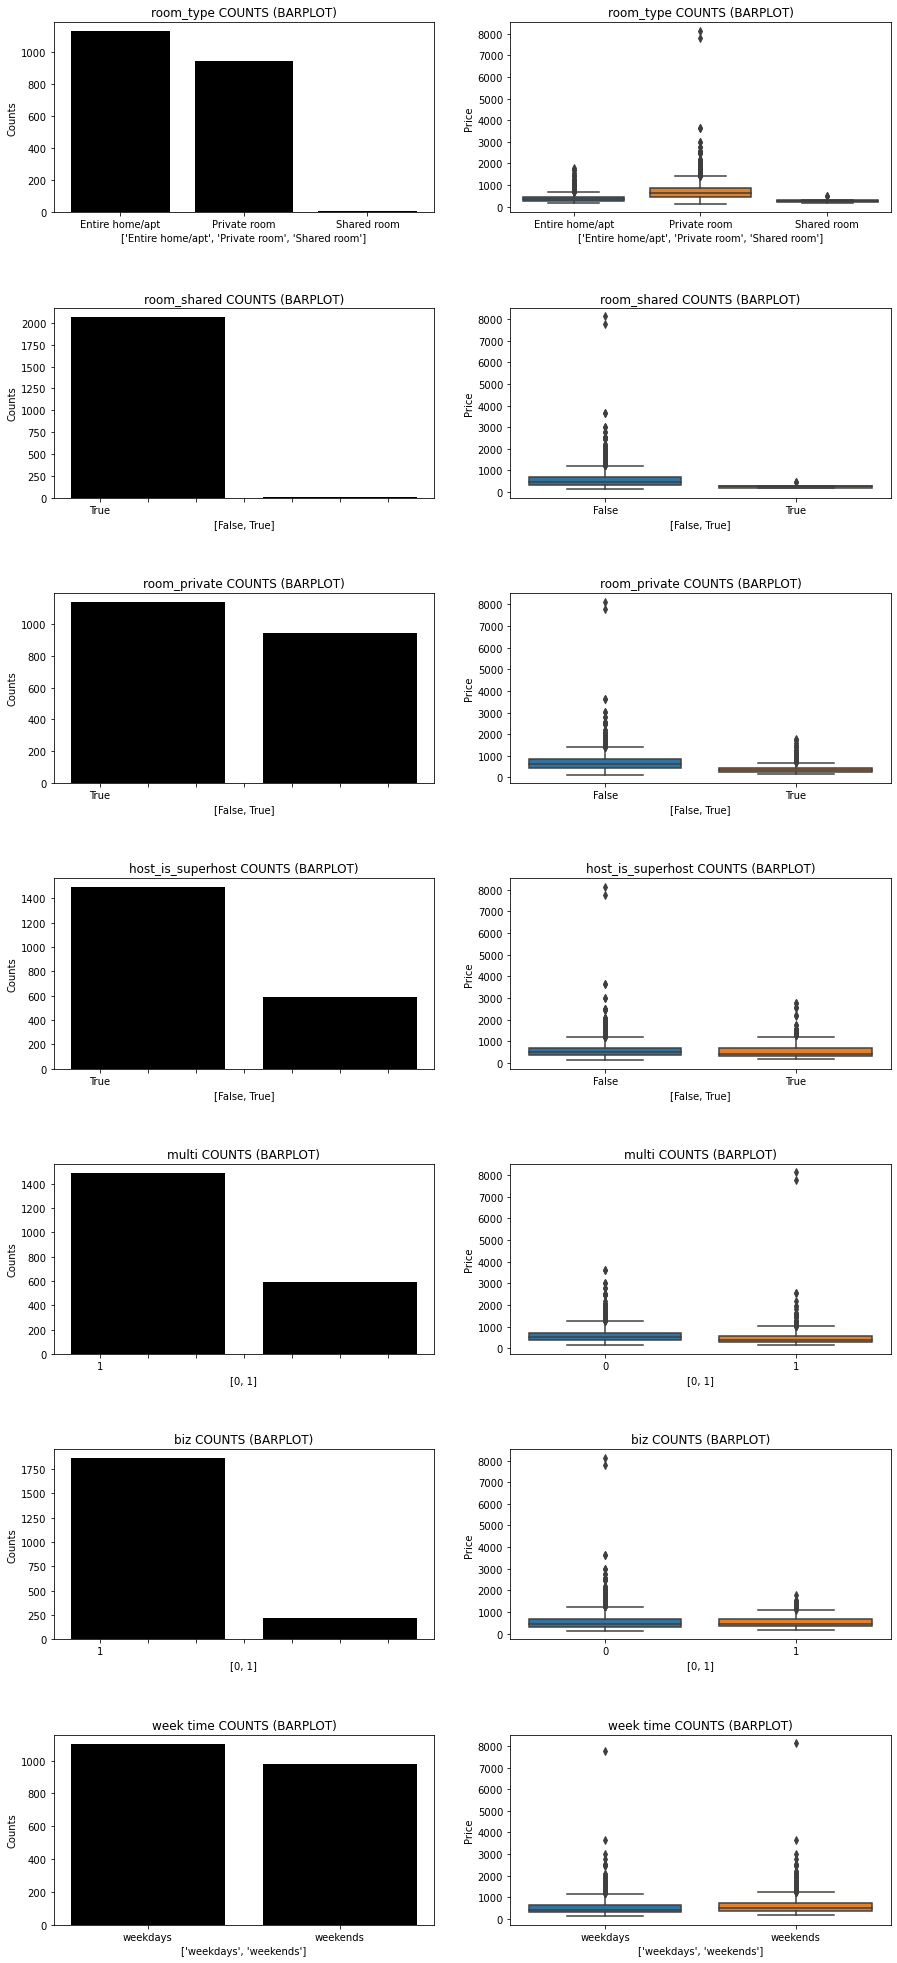

In [44]:
amsterdam_categorical_features = ['room_type','room_shared','room_private','host_is_superhost','multi','biz','week time']

def amsterdam_categorical_distribution_plotter(feature,color,row):
    axes[row,0].bar(x = list(amsterdam[feature].value_counts().index), height=list(amsterdam[feature].value_counts().values),color=color)
    axes[row,0].set_ylabel("Counts")
    axes[row,0].set_xticklabels(list(amsterdam[feature].value_counts().index))
    axes[row,0].set_xlabel(list(amsterdam[feature].value_counts().index))
    axes[row,0].set_title(str(feature)+" COUNTS (BARPLOT)")
    
    sns.boxplot(x = feature ,y = 'realSum', data = amsterdam, ax = axes[row,1])
    axes[row,1].set_ylabel("Price")
    axes[row,1].set_xticklabels(list(amsterdam[feature].value_counts().index))
    axes[row,1].set_xlabel(list(amsterdam[feature].value_counts().index))
    axes[row,1].set_title(str(feature)+" COUNTS (BARPLOT)")

    
plt.figure
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 35))
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[0] , '000000' , 0)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[1] , '000000' , 1)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[2] , '000000' , 2)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[3] , '000000' , 3)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[4] , '000000' , 4)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[5] , '000000' , 5)
amsterdam_categorical_distribution_plotter( amsterdam_categorical_features[6] , '000000' , 6)



plt.subplots_adjust(hspace=0.50)
plt.show()


# <span style="color:#000000; font-size:1em;">DATA PRE-PROCESSING</span>

In [45]:
amsterdam.columns

Index(['realSum', 'room_type', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat', 'week time'],
      dtype='object')

In [54]:
amsterdam.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,week time
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,weekdays
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,weekdays
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,weekdays
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,weekdays
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,weekdays


<p style="color:#2c7873; font-size:1.00em;">
    Replacing True with 1 and False with 0 . The reason being that for a Machine learning model, we need to provide iputs as numeric datatypes, the model cannot make desicions upon any other data types. Thus replacing Boolean strings with equivalent boolean numerics is a step in our data pre-processing 

</p>

In [55]:
amsterdam_2 = amsterdam.replace({False: 0, True: 1})
amsterdam_2

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,week time
0,194.033698,Private room,0,1,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,weekdays
1,344.245776,Private room,0,1,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,weekdays
2,264.101422,Private room,0,1,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,weekdays
3,433.529398,Private room,0,1,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,weekdays
4,485.552926,Private room,0,1,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,weekdays
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,473.132894,Entire home/apt,0,0,2.0,0,0,0,9.0,98.0,0,1.911795,1.723938,283.762206,15.023909,351.969002,30.683248,4.86742,52.36629,weekends
973,491.645771,Entire home/apt,0,0,3.0,0,0,0,10.0,98.0,2,1.478016,1.465641,241.418512,12.782005,312.785000,27.267344,4.88066,52.38412,weekends
974,1812.855904,Entire home/apt,0,0,4.0,0,0,0,8.0,84.0,5,1.943031,0.388542,257.946814,13.657103,336.589450,29.342520,4.90688,52.35794,weekends
975,399.315727,Entire home/apt,0,0,2.0,0,0,0,9.0,89.0,1,3.719001,0.882094,156.045916,8.261917,189.962216,16.560145,4.86056,52.34639,weekends


<p style="color:#2c7873; font-size:1.00em;">
    The room type column remains a categorical column, in order to convert the categorical column to multiple one with integers, that represent the individual categories, we use the get_dummies() function of pandas library
</p>

In [56]:
amsterdam_2['room_type'].value_counts()

Entire home/apt    1126
Private room        944
Shared room          10
Name: room_type, dtype: int64

In [57]:
amsterdam_2_categorical_dummies = pd.get_dummies(amsterdam_2[['room_type','week time']],drop_first=True)
amsterdam_2_dummies = pd.concat([amsterdam_2_categorical_dummies, amsterdam_2.drop(columns=['room_type','week time'])], axis=1)
amsterdam_2_dummies

,room_type_Private room,room_type_Shared room,week time_weekends,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,...,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,1,0,0,194.033698,0,1,2.0,0,1,0,...,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772
1,1,0,0,344.245776,0,1,4.0,0,0,0,...,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432
2,1,0,0,264.101422,0,1,2.0,0,0,1,...,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103
3,1,0,0,433.529398,0,1,4.0,0,0,1,...,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663
4,1,0,0,485.552926,0,1,2.0,1,0,0,...,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,0,0,1,473.132894,0,0,2.0,0,0,0,...,98.0,0,1.911795,1.723938,283.762206,15.023909,351.969002,30.683248,4.86742,52.36629
973,0,0,1,491.645771,0,0,3.0,0,0,0,...,98.0,2,1.478016,1.465641,241.418512,12.782005,312.785000,27.267344,4.88066,52.38412
974,0,0,1,1812.855904,0,0,4.0,0,0,0,...,84.0,5,1.943031,0.388542,257.946814,13.657103,336.589450,29.342520,4.90688,52.35794
975,0,0,1,399.315727,0,0,2.0,0,0,0,...,89.0,1,3.719001,0.882094,156.045916,8.261917,189.962216,16.560145,4.86056,52.34639


<p style="color:#2c7873; font-size:1.00em;">
    by looking at the below heatmap of corellations. It can be seen that the columns obtained after putting dummies and the 'room_shared' and 'room_private' are completely the same and have 1 corellation, which means they are the same thing. THus we will replace the redundant values. Also, since we will scale and normalize the features for use in the models later, thus we will remove the nomralized attraction and restaurant index.<br>
From the 2nd heatmap it can be seen that perfectly corellating features have been removed.
</p>

<AxesSubplot:>

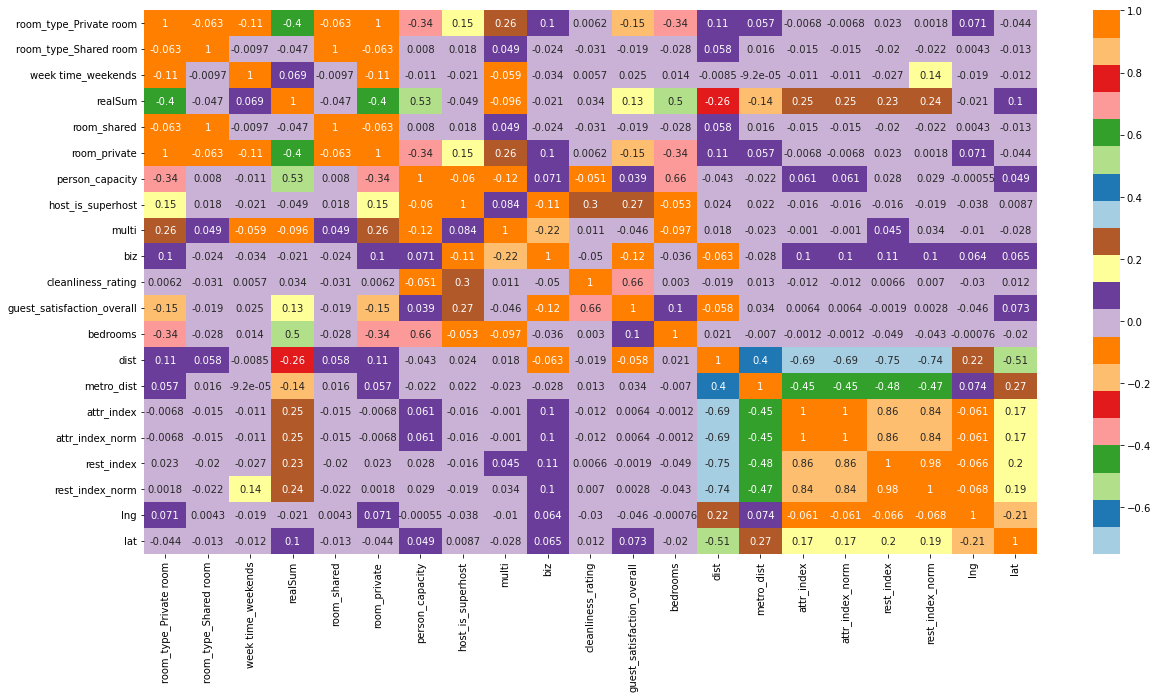

In [58]:
plt.figure
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.heatmap(amsterdam_2_dummies.corr(),cmap=sns.color_palette("Paired",20),annot=True,ax=axes)

In [59]:
amsterdam_2_clean = amsterdam_2_dummies.drop(columns = ['rest_index_norm','attr_index_norm','room_shared','room_private'])
amsterdam_2_clean

,room_type_Private room,room_type_Shared room,week time_weekends,realSum,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat
0,1,0,0,194.033698,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,98.253896,4.90569,52.41772
1,1,0,0,344.245776,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,837.280757,4.90005,52.37432
2,1,0,0,264.101422,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,95.386955,4.97512,52.36103
3,1,0,0,433.529398,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,875.033098,4.89417,52.37663
4,1,0,0,485.552926,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,815.305740,4.90051,52.37508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,0,0,1,473.132894,2.0,0,0,0,9.0,98.0,0,1.911795,1.723938,283.762206,351.969002,4.86742,52.36629
973,0,0,1,491.645771,3.0,0,0,0,10.0,98.0,2,1.478016,1.465641,241.418512,312.785000,4.88066,52.38412
974,0,0,1,1812.855904,4.0,0,0,0,8.0,84.0,5,1.943031,0.388542,257.946814,336.589450,4.90688,52.35794
975,0,0,1,399.315727,2.0,0,0,0,9.0,89.0,1,3.719001,0.882094,156.045916,189.962216,4.86056,52.34639


<AxesSubplot:>

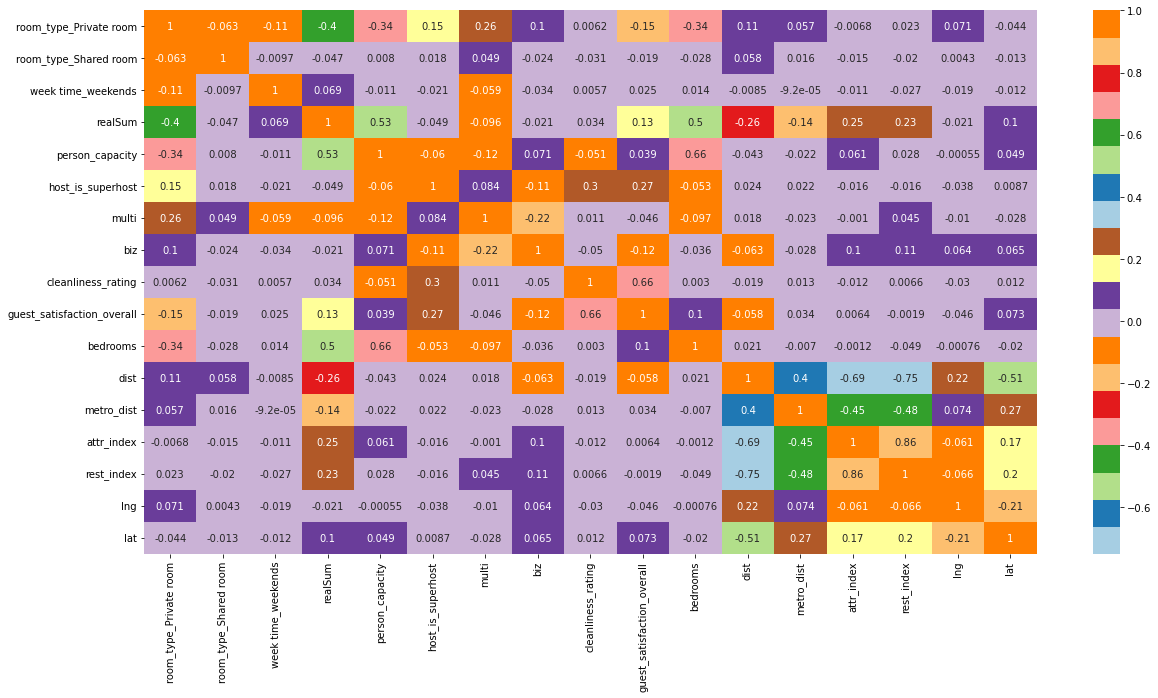

In [60]:
plt.figure
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.heatmap(amsterdam_2_clean.corr(),cmap=sns.color_palette("Paired",20),annot=True,ax=axes)

In [76]:
amsterdam_2_clean

,room_type_Private room,room_type_Shared room,week time_weekends,realSum,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat
0,1,0,0,194.033698,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,98.253896,4.90569,52.41772
1,1,0,0,344.245776,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,837.280757,4.90005,52.37432
2,1,0,0,264.101422,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,95.386955,4.97512,52.36103
3,1,0,0,433.529398,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,875.033098,4.89417,52.37663
4,1,0,0,485.552926,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,815.305740,4.90051,52.37508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,0,0,1,473.132894,2.0,0,0,0,9.0,98.0,0,1.911795,1.723938,283.762206,351.969002,4.86742,52.36629
973,0,0,1,491.645771,3.0,0,0,0,10.0,98.0,2,1.478016,1.465641,241.418512,312.785000,4.88066,52.38412
974,0,0,1,1812.855904,4.0,0,0,0,8.0,84.0,5,1.943031,0.388542,257.946814,336.589450,4.90688,52.35794
975,0,0,1,399.315727,2.0,0,0,0,9.0,89.0,1,3.719001,0.882094,156.045916,189.962216,4.86056,52.34639


In [77]:
amsterdam_3 = amsterdam_2_clean.copy()

In [63]:
def combine_lat_long(lng, lat):
    latitude = np.radians(lat)
    longitude = np.radians(lng)

    amsterdam_latitude = np.radians(52.3676)
    amsterdam_longitude = np.radians(4.9041)

    # apply Haversine formula to compute distance
    latitude_distance = amsterdam_latitude - latitude
    longitude_distance = amsterdam_longitude - longitude
    a = np.sin(latitude_distance/2)**2 + np.cos(latitude) * np.cos(amsterdam_latitude) * np.sin(longitude_distance/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6371 * c

    return distance

In [78]:
amsterdam_3['Haversine Distance'] = combine_lat_long(amsterdam_3['lng'],amsterdam_3['lat'])

In [79]:
amsterdam_3.head()

,room_type_Private room,room_type_Shared room,week time_weekends,realSum,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat,Haversine Distance
0,1,0,0,194.033698,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,98.253896,4.90569,52.41772,5.574134
1,1,0,0,344.245776,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,837.280757,4.90005,52.37432,0.796211
2,1,0,0,264.101422,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,95.386955,4.97512,52.36103,4.877275
3,1,0,0,433.529398,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,875.033098,4.89417,52.37663,1.209398
4,1,0,0,485.552926,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,815.305740,4.90051,52.37508,0.866711


In [134]:
amsterdam_4 = amsterdam_3.copy()
amsterdam_4.drop(columns=['lng','lat'],inplace=True)
amsterdam_4

,room_type_Private room,room_type_Shared room,week time_weekends,realSum,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,Haversine Distance
0,1,0,0,194.033698,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,98.253896,5.574134
1,1,0,0,344.245776,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,837.280757,0.796211
2,1,0,0,264.101422,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,95.386955,4.877275
3,1,0,0,433.529398,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,875.033098,1.209398
4,1,0,0,485.552926,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,815.305740,0.866711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,0,0,1,473.132894,2.0,0,0,0,9.0,98.0,0,1.911795,1.723938,283.762206,351.969002,2.494677
973,0,0,1,491.645771,3.0,0,0,0,10.0,98.0,2,1.478016,1.465641,241.418512,312.785000,2.430254
974,0,0,1,1812.855904,4.0,0,0,0,8.0,84.0,5,1.943031,0.388542,257.946814,336.589450,1.090604
975,0,0,1,399.315727,2.0,0,0,0,9.0,89.0,1,3.719001,0.882094,156.045916,189.962216,3.782226


In [73]:
Standard_Scaler = StandardScaler()

In [135]:
amsterdam_4.columns

Index(['room_type_Private room', 'room_type_Shared room', 'week time_weekends',
       'realSum', 'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'rest_index', 'Haversine Distance'],
      dtype='object')

In [160]:
a4_to_scale = ['person_capacity','cleanliness_rating','guest_satisfaction_overall','bedrooms','dist','metro_dist','attr_index','rest_index','Haversine Distance']
a4_not_to_scale = amsterdam_4[['room_type_Private room','room_type_Shared room','week time_weekends','host_is_superhost','multi','biz','realSum']]
amsterdam_4_numeric_scaled = Standard_Scaler.fit_transform(amsterdam_4[a4_to_scale])
amsterdam_4_numeric_scaled_df = pd.DataFrame(amsterdam_4_numeric_scaled, columns=a4_to_scale)
amsterdam_5 = pd.concat([amsterdam_4_numeric_scaled_df.reset_index(drop=True), a4_not_to_scale.reset_index(drop=True)], axis=1)
amsterdam_5.shape

(2080, 16)

# <span style="color:#a2b3b2; font-size:0.75em;">LINEAR REGRESSION : 

In [165]:
amsterdam_X_train , amsterdam_X_test , amsterdam_Y_train , amsterdam_Y_test = train_test_split(
                                                                                        amsterdam_5.drop(columns=['realSum']) , 
                                                                                        amsterdam_5['realSum'],
                                                                                        random_state=4,
                                                                                        test_size=0.15,
                                                                                        stratify=amsterdam_5['week time_weekends'])
print(amsterdam_X_train.shape)
print(amsterdam_X_test.shape)
print(amsterdam_Y_train.shape)
print(amsterdam_Y_test.shape)

(1768, 15)
(312, 15)
(1768,)
(312,)


In [172]:
amsterdam_LinearRegression = LinearRegression()

In [173]:
amsterdam_LinearRegression.fit(amsterdam_X_train,amsterdam_Y_train)

LinearRegression()

In [174]:
amsterdam_Linear_Regression_fit_evaulation = {'Linear Regression Fit Metrics':
                                    {'Coefficient':amsterdam_LinearRegression.coef_,
                                    'Intercept':amsterdam_LinearRegression.intercept_,
                                    'No. of Features':amsterdam_LinearRegression.n_features_in_,
                                    'R_squared score (Train)':amsterdam_LinearRegression.score(amsterdam_X_train,amsterdam_Y_train),
                                    'R_squared score (Test)':amsterdam_LinearRegression.score(amsterdam_X_test,amsterdam_Y_test)
                                    },
                                   }
amsterdam_Linear_Regression_fit_evaulation = pd.DataFrame(amsterdam_Linear_Regression_fit_evaulation)
amsterdam_Linear_Regression_fit_evaulation

,Linear Regression Fit Metrics
Coefficient,"[133.6344386279648, 4.915944564855888, 25.7824..."
Intercept,626.922359
No. of Features,15
R_squared score (Test),0.529426
R_squared score (Train),0.423946
